# Turn trap pseudopotential analysis

## Import zone

In [59]:
import numpy as np
import scipy.constants as ct
import matplotlib.pyplot as plt

from electrode import System, PolygonPixelElectrode
from copy import deepcopy


from src.systems.modules import TrapConstants
from src.systems.curved_traps import TurnTrap
from src.systems.linear_traps import FiveWireTrap
from src.io.loading import load_turn_geometry, load_fivewire_geometry
from src.geometry.geometry_utils import check_all_ccw
from src.graphics.visualize_trap import plot_trap_with_voltages
from src.graphics.visualize_potential import plot_ps
from src.io.saving import convert_gdsii_to_gdspy
from src.systems.potentials import turn_potential

## Load trap geometry

In [60]:
def stick_systems(system_list, name_list, U_RF, positions, rotations=None):
    electrode_counter = 1
    final_electrodes = []

    for system, system_name in zip(system_list, name_list):
        x_offset, y_offset = positions.get(system_name, (0, 0))
        angle = np.deg2rad(rotations.get(system_name, 0)) if rotations else 0

        for electrode in system:
            e = deepcopy(electrode)
            e.name = f"RF{electrode_counter}"
            electrode_counter += 1

            if hasattr(e, 'paths'):
                e.paths = [
                [(
                    x_offset + (x * np.cos(angle) - y * np.sin(angle)),
                    y_offset + (x * np.sin(angle) + y * np.cos(angle))
                ) for x, y in path]
                for path in e.paths
                ]

            final_electrodes.append((e.name, e.paths))

    assembled_system = System([
        PolygonPixelElectrode(name=name, paths=[np.array(path) for path in paths])
        for name, paths in final_electrodes
    ], name='total_s')

    for e in assembled_system:
        e.rf = U_RF

    return assembled_system




def find_block_limits(electrode_system):
    block_limits = {}

    # Iterate through the electrodes in the system
    for electrode in electrode_system:
        electrode_name = electrode.name
        all_x, all_y = [], []

        # Check if the electrode has the 'paths' attribute
        if hasattr(electrode, 'paths'):  
            # Iterate over the paths (polygons) of the electrode
            for path in electrode.paths:
                # Extract x and y coordinates from each path
                x_values, y_values = zip(*path)  # Unpack coordinates from the path
                all_x.extend(x_values)
                all_y.extend(y_values)

            # Find the min/max limits of the electrode based on the collected coordinates
            x_min, x_max = min(all_x), max(all_x)
            y_min, y_max = min(all_y), max(all_y)

            # Store the limits for each electrode in the block_limits dictionary
            block_limits[electrode_name] = {
                'x_min': x_min, 'x_max': x_max, 
                'y_min': y_min, 'y_max': y_max
            }

    return block_limits


def find_system_limits(electrode_system):
    system_limits = {
        'x_min': float('inf'), 'x_max': float('-inf'),
        'y_min': float('inf'), 'y_max': float('-inf')
    }

    # Iterate through each electrode in the system
    for electrode in electrode_system:
        # Get the individual limits of the current electrode
        electrode_limits = find_block_limits([electrode])[electrode.name]  # Using the previous function

        # Update the overall system limits
        system_limits['x_min'] = min(system_limits['x_min'], electrode_limits['x_min'])
        system_limits['x_max'] = max(system_limits['x_max'], electrode_limits['x_max'])
        system_limits['y_min'] = min(system_limits['y_min'], electrode_limits['y_min'])
        system_limits['y_max'] = max(system_limits['y_max'], electrode_limits['y_max'])

    return system_limits


In [61]:
geometry = load_turn_geometry("src/resources/turn_parameters.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_RF": True,
    "build_DC": False,
    "build_C": False,
    "segment_DC": False,
    "segment_C": False
}

# Set trap constants
trap_constants = TrapConstants(
    L = 1e-6,
    M = 40 * ct.atomic_mass,
    Q = 1 * ct.elementary_charge,
    V_RF = 7,
    Omega = 2 * np.pi * 20e6
)

U_RF = trap_constants.V_RF * np.sqrt(trap_constants.Q / trap_constants.M) / (2 * trap_constants.L * trap_constants.Omega)

# Build trap
turn_trap = TurnTrap(geometry, trench_width, flags)

turn_system = turn_trap.build()

check_all_ccw(turn_system)

geometry = load_fivewire_geometry("src/resources/fivewire_parameters.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_RF": True,
    "build_DC": False,
    "build_C": False,
    "segment_DC": False,
    "segment_C": False
}

# Build trap
trap = FiveWireTrap(geometry, trench_width, flags)
system = trap.build()

check_all_ccw(system)

All electrodes are CCW.
All electrodes are CCW.


In [62]:
systems = [system, turn_system, system]
names = ["s1", "s2", "s3"]

for s in systems:
    print(f'{s.name} limits = {find_system_limits(s)}')

 limits = {'x_min': -750.0, 'x_max': 750.0, 'y_min': -241.5, 'y_max': 241.5}
 limits = {'x_min': -750.0, 'x_max': 241.5, 'y_min': -750.0, 'y_max': 241.5}
 limits = {'x_min': -750.0, 'x_max': 750.0, 'y_min': -241.5, 'y_max': 241.5}


In [63]:
# Positions for each system
positions = {
    's1': (-750, 750),  # First linear
    's2': (750, 750),       # Turn
    's3': (750, -750),  # Second linear
}

rotations = {
    's1': 0,
    's2': 0,
    's3': -90,
}

# Stick the systems together
assembled_system = stick_systems(systems, names, U_RF, positions, rotations)
check_all_ccw(assembled_system)

All electrodes are CCW.


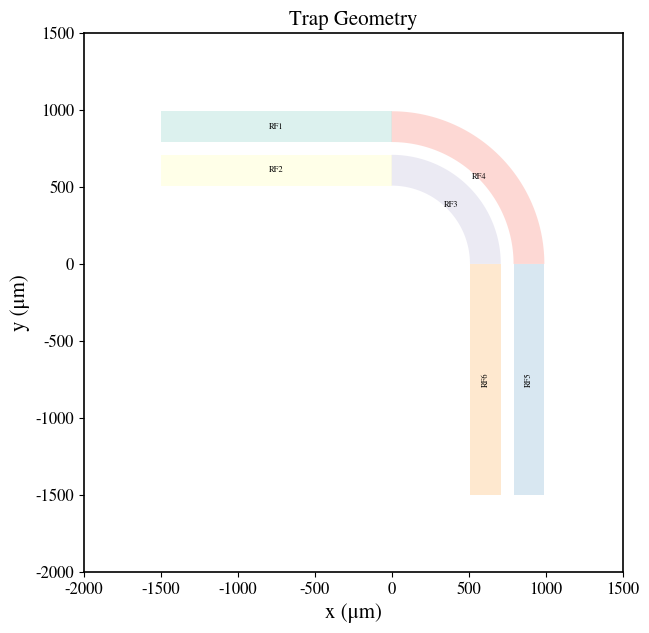

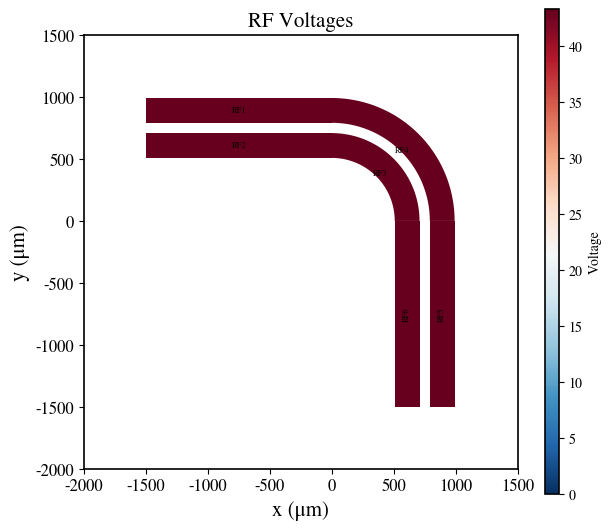

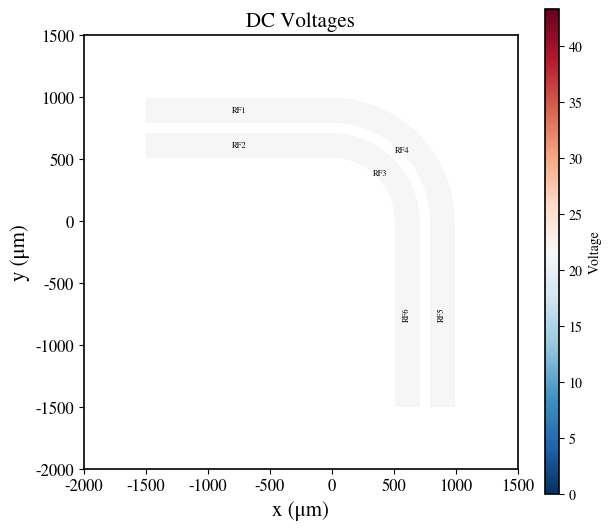

In [64]:
plot_trap_with_voltages(assembled_system, [-2000, 1500], [-2000, 1500])

## Pseudopotential analysis

In [65]:
horizontal_values = np.linspace(-750, 0, 1001)
vertical_values = np.linspace(0, -750, 1001) 
theta = np.linspace(np.pi/2, 0, 1001)

horizontal_path = [(x, 750, 110.0) for x in horizontal_values]
vertical_path = [(750, y, 110.0) for y in vertical_values]
curved_path = [(750 * np.cos(t), 750 * np.sin(t), 110.0) for t in theta]

path = horizontal_path + curved_path + vertical_path

# Define axes:
# - Horizontal motion: optimize in (y, z) → axes 1, 2
# - Curved motion: optimize only in z → axis 2
# - Vertical motion: optimize in (x, z) → axes 0, 2
axis_path = (
  [(1, 2)] * len(horizontal_path) +
  [(2,)] * len(curved_path) +
  [(0, 2)] * len(vertical_path)
)

results = turn_potential(assembled_system, trap_constants, path, axis_path)

In [66]:
# Compute maximum q-factor
max_q = (max(results["omega_sec_values"][:, 0]))/trap_constants.Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/trap_constants.V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*trap_constants.V_RF))

max q-parameter 0.0824, max q-param per Volt 0.0118
--> apply 34V for max q=0.4


In [67]:
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

# Choose matplotlib options
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,             # base font size
    "axes.labelsize": 15,        # x/y labels
    "axes.titlesize": 15,        # title
    "xtick.labelsize": 12,       # tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 12,       # legend
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,      # thicker default lines
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

def plot_ps(x_values, pseudopot_values, grad_values, positions, omega_sec):
    # Convert inputs to numpy arrays for safety
    x_values = np.array(x_values)
    pseudopot_values = np.array(pseudopot_values)/1e-3
    grad_values = np.array(grad_values)/1e-3
    positions = np.array(positions)
    omega_sec = np.array(omega_sec)

    # Define a scientific formatter
    sci_formatter = ScalarFormatter(useMathText=True)
    sci_formatter.set_powerlimits((-3, 3))

    # === Combined figure with three subplots ===
    fig1, (ax1, ax2, ax3) = plt.subplots(
        3, 1,                # 2 rows, 1 column
        figsize=(6, 6),      # adjust as needed
        sharex=True           # share x-axis
    )

    # === Top subplot: Pseudo-potential ===
    ax1.plot(
        x_values,
        pseudopot_values,
        color="#003366",    # dark blue
        label="Pseudo-potential"
    )
    ax1.set_ylabel(r"$\Phi_{PS} \ [\mathrm{meV}]$", labelpad=20)
    ax1.grid(True)
    # ax1.legend(loc='upper left')
    ax1.yaxis.set_major_formatter(sci_formatter)

    # === Mid subplot: Gradient ===
    ax2.plot(
        x_values,
        grad_values,
        color="#8B0000",    # deep red
        label=r"$\nabla_x \Phi_{PS}$"
    )
    ax2.set_ylabel(r"$\nabla_x \Phi_{PS} \ [\mathrm{meV} / \mathrm{\mu m}]$")
    ax2.grid(True)
    # ax2.legend(loc='upper left')
    ax2.xaxis.set_major_formatter(sci_formatter)
    ax2.yaxis.set_major_formatter(sci_formatter)

    # === Bottom subplot: Position of the minimum ===
    # ax3.plot(x_values, positions[:, 0], label='X Position')
    # ax3.plot(x_values, positions[:, 1], label='Y Position')

    # Z minimum in dark green
    ax3.plot(
        x_values,
        positions[:, 2],
        color="#006400",    # dark green
        label="Z minimum"
    )

    # Reference line at y = 100 μm in gray dashed
    ax3.plot(
        x_values,
        [100]*len(x_values),
        color="black",
        linestyle="--",
        linewidth=1.2,
        alpha=0.8,
        label=r"$y = 100\,\mathrm{\mu m}$"
    )

    ax3.set_xlabel(r"$x \ [\mathrm{\mu m}]$")
    ax3.set_ylabel(r"$h \ [\mathrm{\mu m}]$", labelpad=13)
    # ax3.legend(loc='upper left')
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(sci_formatter)
    ax3.yaxis.set_major_formatter(sci_formatter)

    # Define the start of the shaded region
    x_shade_start = -41.5
    x_shade_end = 0  # or any other maximum

    # Add the shaded region to all three subplots
    for ax in [ax1, ax2, ax3]:
        ax.axvspan(
            x_shade_start,
            x_shade_end,
            color="#EEE8AC",
            alpha=0.5  # transparency
        )
        ax.axvspan(
            x_shade_start - 199,
            x_shade_start,
            color="#FBC901",
            alpha=0.5
        )


    plt.tight_layout()
    plt.show()

    # === Figure 2: Radial secular frequencies ===
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    # var_radial_1 = np.var(omega_sec[:, 1] / (2 * np.pi) / 1e6)
    # var_radial_2 = np.var(omega_sec[:, 2] / (2 * np.pi) / 1e6)
    ax2.plot(x_values, omega_sec[:, 0] / (2 * np.pi) / 1e6,
             label=r"$\omega_x$ (axial)", color='#003366')
    ax2.plot(x_values, omega_sec[:, 1] / (2 * np.pi) / 1e6,
             label=r"$\omega_y$ (radial)", color='#006400')
    ax2.plot(x_values, omega_sec[:, 2] / (2 * np.pi) / 1e6,
             label=r"$\omega_z$ (radial)", color='#8B0000')
    ax2.set_ylabel(r"Frequency $\ \ [\mathrm{MHz}]$")
    ax2.set_xlabel(r"$x \ \ [\mathrm{\mu m}]$")
    ax2.legend(loc='best')
    ax2.grid(True)
    # ax2.xaxis.set_major_formatter(sci_formatter)
    # ax2.yaxis.set_major_formatter(sci_formatter)
    
    ax2.axvspan(
            x_shade_start,
            x_shade_end,
            color="#EEE8AC",
            alpha=0.5  # transparency
        )
    ax2.axvspan(
            x_shade_start - 199,
            x_shade_start,
            color="#FBC901",
            alpha=0.5
        )
    
    plt.tight_layout()
    plt.show()

    return fig1, fig2

In [68]:
x = np.linspace(-750, 750, 3003)

In [69]:
grad_values = np.gradient(results['pseudopot_values'], x)

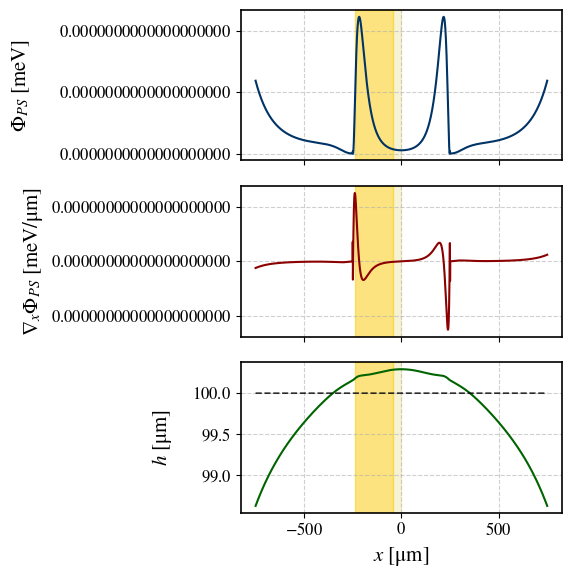

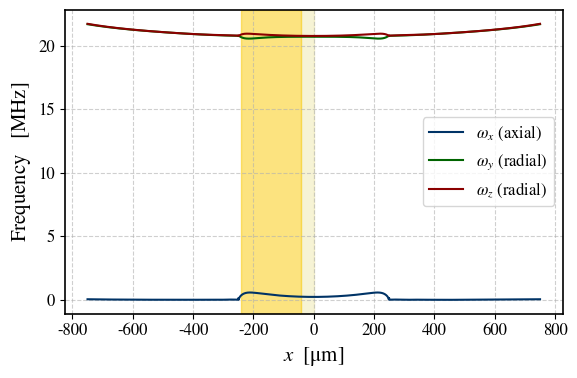

(<Figure size 600x600 with 3 Axes>, <Figure size 600x400 with 1 Axes>)

In [71]:
plot_ps(x, results['pseudopot_values'], grad_values, results['positions'], results['omega_sec_values'])